In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_tfrecord_test_files function

from generate_input_files.generate_tfrecord_test_files import generate_tfrecord_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [2]:
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "tfrecord_test")

# Call the function to generate files
print("Generating MNIST test files...")
generated_files = generate_tfrecord_test_files(tmp_folder)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_filename = generated_files["model"]

Generating MNIST test files...
TFRecord dataset saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\tfrecord_test\winequality.tfrecord
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\tfrecord_test\winequality_tfrecord_definition.yaml
Model saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\tfrecord_test\winequality_tfrecord_model.keras
File generation completed.


In [15]:
# Define the API URL
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"

# Prepare the files and data for the request
files = {
    "model": open(model_filename, "rb"),
    "dataset": open(dataset_filename, "rb"),
    "dataset_definition": open(yaml_filename, "rb"),
}
data = {
    "framework": "TensorFlow 2.16.1",
    "model_name": "tfrecord_analysis_model",
    "epochs": 50,
}

# Submit the job
print("Submitting the tfrecord training job to the API...")
response = requests.post(API_URL, files=files, data=data)
print(f"Submitted: {response.status_code} {response.text}")

# Extract the unique_dir from the API response
response_data = response.json()
unique_dir = response_data.get("unique_dir")
if not unique_dir:
    raise ValueError("Error: 'unique_dir' not found in the API response.")

Submitting the tfrecord training job to the API...
Submitted: 200 {"job_id":"16bc6dd6-5c67-429e-832a-9adf1795c044","status":"Training started","unique_dir":"9cc2c48f-3903-42be-805a-ea5d2643568e"}


In [16]:
import boto3
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download

# MinIO configuration
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "basic_eval" ,"tfrecord_test")

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Wait for the job to finish and download the results
wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
print(f"Artifacts downloaded to: {DOWNLOAD_DIR}")

Checking if job is finished by looking for 'output' folder in '9cc2c48f-3903-42be-805a-ea5d2643568e'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in '9cc2c48f-3903-42be-805a-ea5d2643568e'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in '9cc2c48f-3903-42be-805a-ea5d2643568e'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in '9cc2c48f-3903-42be-805a-ea5d2643568e'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in '9cc2c48f-3903-42be-805a-ea5d2643568e'...
Downloaded: 9cc2c48f-3903-42be-805a-ea5d2643568e/dataset/winequality.tfrecord -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tfrecord_test\9cc2c48f-3903-42be-805a-ea5d2643568e/dataset/winequality.tfrecord
Downloaded: 9cc2c48

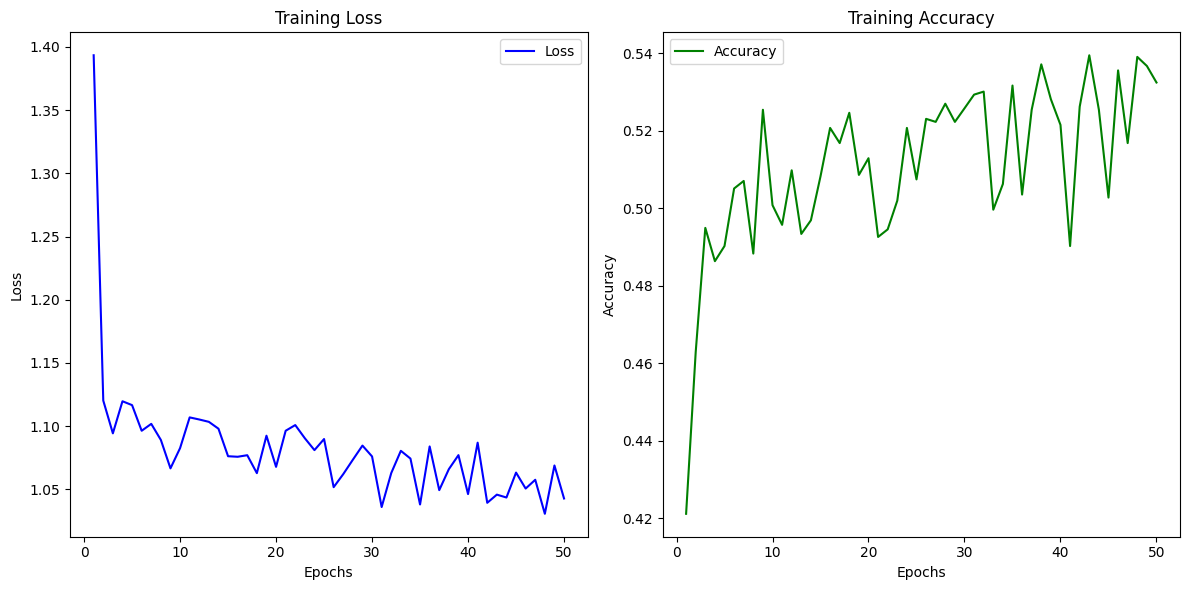


Contents of c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tfrecord_test\9cc2c48f-3903-42be-805a-ea5d2643568e\output\logs.log:
2025-05-24 12:35:09,913 - INFO - Grouped BOM data generated successfully.
2025-05-24 12:35:09,913 - INFO - Transforming BOM data to CycloneDX format...
2025-05-24 12:35:09,959 - INFO - Signing BOM data...
2025-05-24 12:35:09,963 - INFO - BOM signed
2025-05-24 12:35:09,963 - INFO - serializing BOM data...
2025-05-24 12:35:10,025 - INFO - BOM serialized: /tmp/9cc2c48f-3903-42be-805a-ea5d2643568e/cyclonedx_bom.json
2025-05-24 12:35:10,025 - INFO - Uploading bom to MinIO...
2025-05-24 12:35:10,035 - INFO - Task completed successfully.
2025-05-24 12:35:10,036 - INFO - Task 16bc6dd6-5c67-429e-832a-9adf1795c044 completed.
2025-05-24 12:35:10,036 - INFO - Uploading application_logs to MinIO. Size: 3651 bytes

Contents of c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\basic_eval\tfre

In [17]:
import time
import json
import matplotlib.pyplot as plt

# Define the paths to the downloaded files
output_dir = os.path.join(root_dir, "results", "basic_eval", "tfrecord_test", unique_dir, "output")
metrics_file = os.path.join(output_dir, "metrics.json")
logs_file = os.path.join(output_dir, "logs.log")
cyclonedx_file = os.path.join(output_dir, "cyclonedx_bom.json")

# Load and plot metrics.json
if os.path.exists(metrics_file):
    with open(metrics_file, "r") as f:
        metrics = json.load(f)
    
    # Plot training loss and accuracy
    if "loss" in metrics and "accuracy" in metrics:
        epochs = range(1, len(metrics["loss"]) + 1)
        
        plt.figure(figsize=(12, 6))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, metrics["loss"], label="Loss", color="blue")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, metrics["accuracy"], label="Accuracy", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("Metrics file does not contain 'loss' or 'accuracy'.")
else:
    print(f"Metrics file not found at {metrics_file}.")

# Analyze logs.log
if os.path.exists(logs_file):
    print(f"\nContents of {logs_file}:")
    with open(logs_file, "r") as f:
        logs = f.readlines()
        for line in logs[-10:]:  # Print the last 10 lines of the log file
            print(line.strip())
else:
    print(f"Logs file not found at {logs_file}.")

# Analyze cyclonedx_bom.json
if os.path.exists(cyclonedx_file):
    print(f"\nContents of {cyclonedx_file}:")
    with open(cyclonedx_file, "r") as f:
        cyclonedx_data = json.load(f)
        print(json.dumps(cyclonedx_data, indent=4)[:500])  # Print the first 500 characters
else:
    print(f"CycloneDX BOM file not found at {cyclonedx_file}.")